In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# File Setup

Set the file path of where we will be taking the images from

In [2]:
datasetFile = 'Dataset\Zip\Dataset - 2 Sec Chucks, 1.5  Sec Overlap.zip'

Loading all of the images in the files and placing it into a dataframe object called data

In [3]:
filesNames = []
person = []
with ZipFile(datasetFile) as zf:
    for file in zf.namelist():
        if file.endswith(".jpg") or file.endswith(".png"):
            
            if "MACOSX" not in file:
                filesNames.append(file)
                person.append(file.split('/')[-2])
            
            
Filename = pd.DataFrame(filesNames, columns=['Filename'])
person = pd.DataFrame(person, columns=['Person'])

data = pd.concat([Filename, person], axis=1)

This is what the data looks like

In [4]:
data

,Filename,Person
0,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast
1,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast
2,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast
3,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast
4,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast
...,...,...
219954,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown
219955,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown
219956,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown
219957,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown


Because a Nueral network cant understand letters we need to Hot Encode all of the letters to turn them into numbers.

So we create a column for each letter and if its that letter than we place a 1 in the cell otherwise we place a 0.

See below

In [5]:
labels_encoded = data['Person'].str.get_dummies()

# Concatenate the new DataFrame with the original DataFrame
df_encoded = pd.concat([data, labels_encoded], axis=1)

This is what is looks like

In [6]:
df_encoded

,Filename,Person,3Blue1Brown,A Better You Podcast,Just Alex Podcast,Solo Flight Podcast
0,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
1,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
2,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
3,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
4,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
...,...,...,...,...,...,...
219954,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown,1,0,0,0
219955,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown,1,0,0,0
219956,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown,1,0,0,0
219957,3Blue1Brown/Winding numbers and domain colorin...,3Blue1Brown,1,0,0,0


# Splitting the data into Training, Test and Validation sets

Here we break down the hot encoded data into a training, test and validation split.

We use the split of:
- Training: 80%
- Test: 10%
- Validation: 10%

In [7]:
from sklearn.model_selection import train_test_split

# Split data into training and temporary data
train_data, temp_data = train_test_split(df_encoded, test_size=0.2, random_state=42)

# Split the temporary data into validation and test data
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the sizes of the datasets
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(valid_data)}")
print(f"Test set size: {len(test_data)}")

X_train = np.array(train_data['Filename'])
Y_train = np.array(train_data.drop(columns=['Filename', 'Person']))

X_valid = np.array(valid_data['Filename'])
Y_valid = np.array(valid_data.drop(columns=['Filename', 'Person']))

X_test = np.array(test_data['Filename'])
Y_test = np.array(test_data.drop(columns=['Filename', 'Person']))

Training set size: 175967
Validation set size: 21996
Test set size: 21996


Here we double check the size of the split data. We are making sure that the X and Y have the same size in the first column as they need to be equal.

Secondly we are seeing the size of the number 29. This number represent the number of output neurons that we will see in the Neural network

In [8]:
print(X_train.shape)
print(Y_train.shape)

(175967,)
(175967, 4)


This is what the training data looks likes

NOTE: We still need to turn the FileName to an actual image, we will do this in the loading block of code

In [9]:
train_data.head()

,Filename,Person,3Blue1Brown,A Better You Podcast,Just Alex Podcast,Solo Flight Podcast
63186,A Better You Podcast/HOW TO FEEL YOUR BEST FRO...,A Better You Podcast,0,1,0,0
935,A Better You Podcast/22 THINGS I LEARNED BY 22...,A Better You Podcast,0,1,0,0
213707,3Blue1Brown/Visualizing quaternions (4d number...,3Blue1Brown,1,0,0,0
57908,A Better You Podcast/HOW TO EMBRACE THE MUNDAN...,A Better You Podcast,0,1,0,0
135842,A Better You Podcast/YOUR GUIDE TO SOCIAL CONF...,A Better You Podcast,0,1,0,0


In [10]:
classes = list(train_data.drop(columns=['Filename', 'Person']).columns)
classes

['3Blue1Brown',
 'A Better You Podcast',
 'Just Alex Podcast',
 'Solo Flight Podcast']

# Loading and Preprocessing Images

Here we apply 5 filters:
- Median filter for Salt and Pepper noise
- Gaussian Blurring for Gaussian noise
- Median filter for Uniform noise
- Resizing the image
- Normalize image to place all values of RGB between 0 and 1

In [11]:
def preprocessImage(img, imageSize):
    # Step 4: Resize the image to be used in the AI Algorithm
    uniform_filtered = cv2.resize(img, imageSize)
    
    # Step: 5 Normalize image to place all values of RGB between 0 and 1
    normalized_filtered = uniform_filtered / 255.0 
    
    return normalized_filtered

Here we load in all of the images. We turn the filename column into an image column.

NOTE: The reason we use an image generator is because we want to load the images in segments as if we were to load in all the images at once the Memory / RAM on the PC would fill up causing the program to crash

In [12]:
img_size = cv2.imread('Dataset/Spectrogram/3Blue1Brown/spectrogram_chunk_1.png').shape[:2]
img_size

(308, 51)

In [13]:
# Define image size and batch size
batch_size = 32  # Define a batch size

# Custom generator to load images in batches from a zip file
def image_generator(file_list, label_list, zip_file, batch_size):
    while True:  # Loop indefinitely so the generator can be used in keras .fit()
        for start in range(0, len(file_list), batch_size):
            end = min(start + batch_size, len(file_list))
            batch_files = file_list[start:end]
            batch_labels = label_list[start:end]
            
            batch_images = []
            for file in batch_files:
                # Preprocess image
                with zip_file.open(file) as img_file:
                    img = cv2.imdecode(np.frombuffer(img_file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = preprocessImage(img, img_size)

                        batch_images.append(img)
                    else:
                        print(f"Warning: Image {file} could not be loaded.")
            
            yield np.array(batch_images), np.array(batch_labels)

# Open the zip file once to use inside the generator
zip_file = ZipFile(datasetFile)

# Prepare data for the generator
X_train_files = np.array(train_data['Filename'])
Y_train_labels = np.array(train_data.drop(columns=['Filename', 'Person']))

X_valid_files = np.array(valid_data['Filename'])
Y_valid_labels = np.array(valid_data.drop(columns=['Filename', 'Person']))

# Create generators for training and validation
train_gen = image_generator(X_train_files, Y_train_labels, zip_file, batch_size)
valid_gen = image_generator(X_valid_files, Y_valid_labels, zip_file, batch_size)

# Calculate steps per epoch for training and validation
train_steps = len(X_train_files) // batch_size
valid_steps = len(X_valid_files) // batch_size


# CNN

Here we build a basic CNN architecture to do a classification of the images. 

NOTE: There are better models however we have chosen a more simple model to classify as we want the model to be faster when running 

In [14]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import TensorBoard

# Set input shape to match (308, 51, 1)
x, y = img_size
input_shape = (x, y, 1)

# Define model architecture
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11, 11), 
                              strides=(4, 4), activation="relu", 
                              input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5), 
                              strides=(1, 1), activation="relu", 
                              padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), 
                              strides=(1, 1), activation="relu", 
                              padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), 
                              strides=(1, 1), activation="relu", 
                              padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3), 
                              strides=(1, 1), activation="relu", 
                              padding="same"))
model.add(keras.layers.BatchNormalization())
# Reduce the pooling size here to (2, 2) to prevent negative dimensions
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation="softmax"))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Callbacks
checkpoint = ModelCheckpoint('best_model_CNN_1.5_Overlap.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Add the callbacks to a list
callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

# Fit the model using the generators with callbacks
history = model.fit(
    train_gen, 
    steps_per_epoch=train_steps, 
    epochs=300, 
    validation_data=valid_gen, 
    validation_steps=valid_steps, 
    callbacks=callbacks
)


Epoch 1/300
5496/5498 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9427
Epoch 1: val_loss improved from inf to 0.10285, saving model to best_model_CNN_1.5_Overlap.keras
5498/5498 [==============================] - 134s 24ms/step - loss: 0.1639 - accuracy: 0.9427 - val_loss: 0.1028 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 2/300
5498/5498 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9794
Epoch 2: val_loss improved from 0.10285 to 0.01191, saving model to best_model_CNN_1.5_Overlap.keras
5498/5498 [==============================] - 131s 24ms/step - loss: 0.0655 - accuracy: 0.9794 - val_loss: 0.0119 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 3/300
5497/5498 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9891
Epoch 3: val_loss did not improve from 0.01191
5498/5498 [==============================] - 131s 24ms/step - loss: 0.0389 - accuracy: 0.9891 - val_loss: 0.0326 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 4/300

Here we can see the training and test accuracy while the model is learning.

NOTE: When the training data goes about the test data it means that the model is starting to overfit. This is bad as it means the CNN will preform worse on unseen data

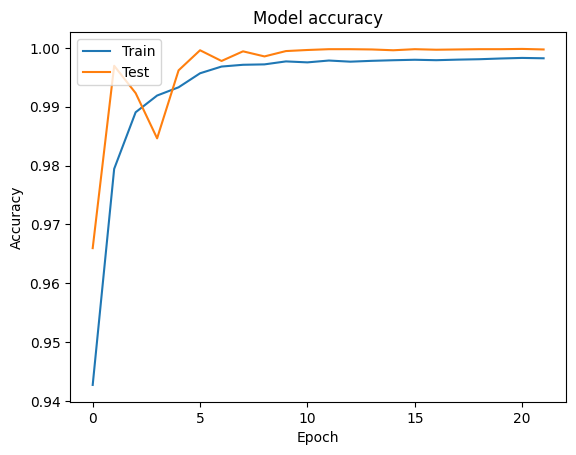

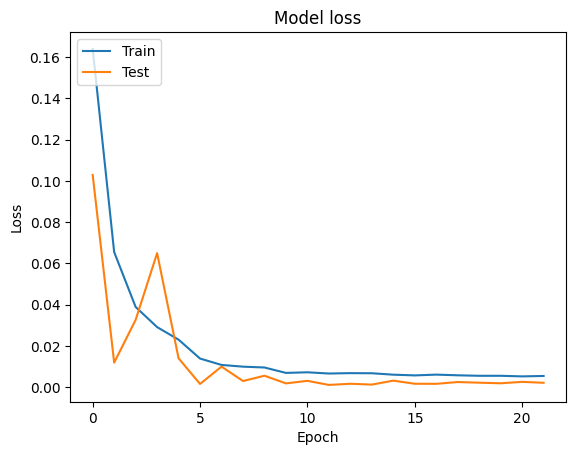

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

687/687 [==============================] - 13s 19ms/step


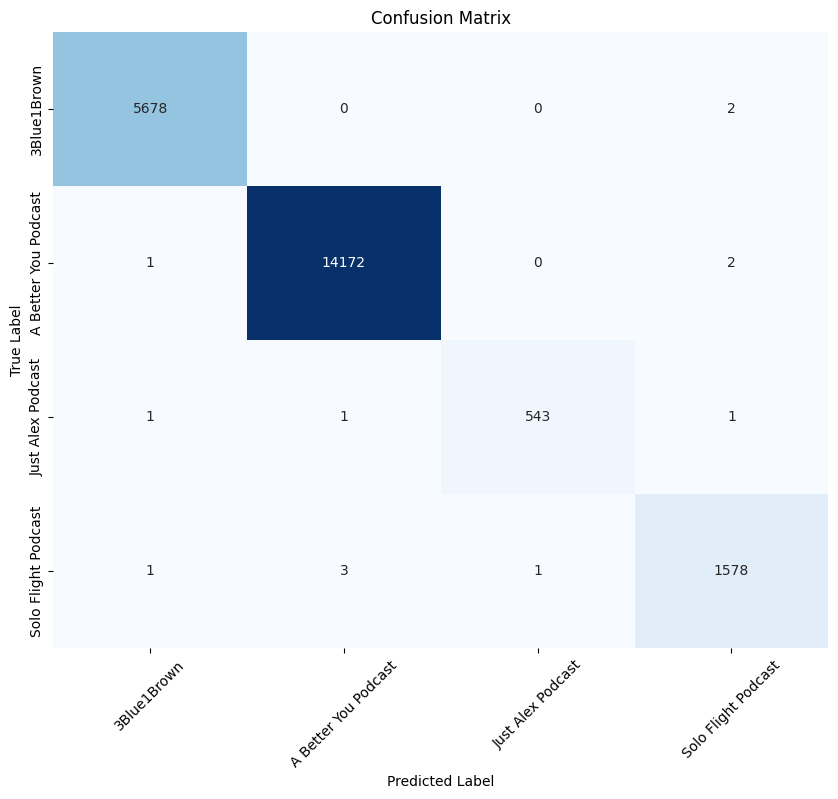

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Prepare test data generator
X_test_files = np.array(test_data['Filename'])
Y_test_labels = np.array(test_data.drop(columns=['Filename', 'Person']))

test_gen = image_generator(X_test_files, Y_test_labels, zip_file, batch_size)
test_steps = len(X_test_files) // batch_size

# Get predictions from the model
Y_pred_probs = model.predict(test_gen, steps=test_steps)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Convert one-hot encoded true labels to categorical format
Y_true = np.argmax(Y_test_labels[:len(Y_pred)], axis=1)

# Assuming y_true and y_pred are your actual and predicted labels
cm = confusion_matrix(Y_true, Y_pred)

# Define class labels if needed
class_labels = classes  # Use your own class list here

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

# Rotate the bottom labels (x-axis labels) vertically
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


687/687 [==============================] - 13s 20ms/step


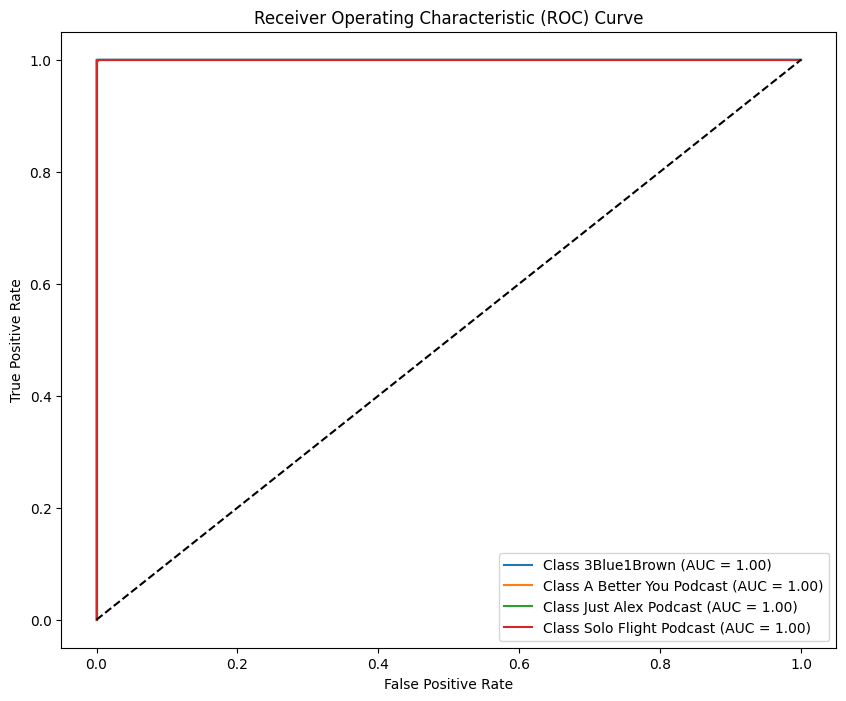

In [17]:
from sklearn.metrics import roc_curve, auc
# Get predicted probabilities for the model on the test set
Y_pred_probs = model.predict(test_gen, steps=test_steps)

# Convert one-hot encoded true labels to categorical format
Y_true = np.argmax(Y_test_labels[:len(Y_pred_probs)], axis=1)

# Initialize a plot for ROC curves
plt.figure(figsize=(10, 8))

# Loop through each class and compute the ROC curve and AUC
for i in range(len(classes)):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y_true == i, Y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random predictions
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Get predictions from the model
Y_pred_probs = model.predict(test_gen, steps=test_steps)

# Convert one-hot encoded true labels to categorical format
Y_true = np.argmax(Y_test_labels[:len(Y_pred_probs)], axis=1)

# Get the predicted class labels
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision (average='weighted' to account for class imbalance)
precision = precision_score(Y_true, Y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall (average='weighted' to account for class imbalance)
recall = recall_score(Y_true, Y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Calculate F1 score (average='weighted' to account for class imbalance)
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


687/687 [==============================] - 13s 19ms/step
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F1 Score: 0.9994


: 